In [1]:
import sys
import torch
from torch import nn
sys.path.insert(0, '../../')
from lib import dlm

In [3]:
class LSTMScratch(dlm.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                         init_weight(num_hiddens, num_hiddens),
                         nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [4]:
@dlm.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    H, C = None, None if H_C is None else H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) + (
            torch.matmul(H, self.W_hi) if H is not None else 0) + self.b_i)
        if H is None:
            H, C = torch.zeros_like(I), torch.zeros_like(I)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

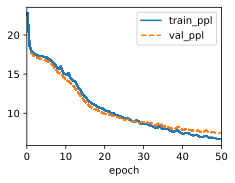

In [5]:
data = dlm.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = dlm.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = dlm.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, dlm.try_gpu())

'it has ale ale ale ale ale'